In [1]:
# Librerie principali

import numpy as np # linear algebra
import pandas as pd
import geopandas as gpd
import zipfile
import sklearn
import warnings
import json
warnings.filterwarnings('ignore')
from datetime import datetime
import statsmodels.api as sm
import seaborn as sns
from matplotlib import pyplot as plt
import folium

# Model Libraries
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, PolynomialFeatures, StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.compose import ColumnTransformer
from sklearn.inspection import permutation_importance

# Testing libraries
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, StratifiedKFold, GridSearchCV, learning_curve
from sklearn.metrics import accuracy_score, log_loss, confusion_matrix, classification_report, roc_curve, auc, ConfusionMatrixDisplay, f1_score, precision_score, recall_score, roc_auc_score, make_scorer

se si vuole caricare solo la tabella finale unificata

In [2]:
trans_final = pd.read_pickle('./trans_final.pkl')
trans_final.head()

id_trans  client_id_trans  card_id  amount           use_chip  merchant_id  \
0   7475327             1556     2972  -77.00  Swipe Transaction        59935   
1   7475328              561     4575   14.57  Swipe Transaction        67570   
2   7475329             1129      102   80.00  Swipe Transaction        27092   
3   7475331              430     2860  200.00  Swipe Transaction        27092   
4   7475332              848     3915   46.41  Swipe Transaction        13051   

  merchant_city merchant_state         day      time  ...  \
0        Beulah             ND  2010-01-01  00:01:00  ...   
1    Bettendorf             IA  2010-01-01  00:02:00  ...   
2         Vista             CA  2010-01-01  00:02:00  ...   
3   Crown Point             IN  2010-01-01  00:05:00  ...   
4       Harwood             MD  2010-01-01  00:06:00  ...   

                    address  latitude longitude per_capita_income  \
0  594 Mountain View Street     46.80   -100.76           23679.0   
1           604 Pine Street     40.80    -91.12           18076.0   
2          2379 Forest Lane     33.18   -117.29           16894.0   
3        903 Hill Boulevard     41.42    -87.35           26168.0   
4           166 River Drive     38.86    -76.60           33529.0   

  yearly_income total_debt  credit_score  num_credit_cards years_to_retire  \
0       48277.0   110153.0           740                 4              37   
1       36853.0   112139.0           834                 5              19   
2       34449.0    36540.0           686                 3              16   
3       53350.0   128676.0           685                 5              15   
4       68362.0    96182.0           711                 2              18   

                         mcc_description  
0              Miscellaneous Food Stores  
1                      Department Stores  
2                         Money Transfer  
3                         Money Transfer  
4  Drinking Places (Alcoholic Beverages)  

[5 rows x 36 columns]

In [3]:
trans_final.columns

Index(['id_trans', 'client_id_trans', 'card_id', 'amount', 'use_chip',
       'merchant_id', 'merchant_city', 'merchant_state', 'day', 'time',
       'fraud', 'client_id_card', 'card_brand', 'card_type', 'expires',
       'has_chip', 'num_cards_issued', 'credit_limit', 'acct_open_date',
       'year_pin_last_changed', 'card_valid_month', 'id', 'current_age',
       'retirement_age', 'birth_year', 'gender', 'address', 'latitude',
       'longitude', 'per_capita_income', 'yearly_income', 'total_debt',
       'credit_score', 'num_credit_cards', 'years_to_retire',
       'mcc_description'],
      dtype='object')

Estrazione delle tabelle e visualizzazione della corretta estrazione

In [4]:
with zipfile.ZipFile('./archive.zip', 'r') as zip_ref:
  with zip_ref.open('transactions_data.csv') as f:
        trans = pd.read_csv(f)
  with zip_ref.open('users_data.csv') as f:
        users = pd.read_csv(f)
  with zip_ref.open('cards_data.csv') as f:
        cards = pd.read_csv(f)


In [5]:
trans.head()

id                 date  client_id  card_id   amount  \
0  7475327  2010-01-01 00:01:00       1556     2972  $-77.00   
1  7475328  2010-01-01 00:02:00        561     4575   $14.57   
2  7475329  2010-01-01 00:02:00       1129      102   $80.00   
3  7475331  2010-01-01 00:05:00        430     2860  $200.00   
4  7475332  2010-01-01 00:06:00        848     3915   $46.41   

            use_chip  merchant_id merchant_city merchant_state      zip   mcc  \
0  Swipe Transaction        59935        Beulah             ND  58523.0  5499   
1  Swipe Transaction        67570    Bettendorf             IA  52722.0  5311   
2  Swipe Transaction        27092         Vista             CA  92084.0  4829   
3  Swipe Transaction        27092   Crown Point             IN  46307.0  4829   
4  Swipe Transaction        13051       Harwood             MD  20776.0  5813   

  errors  
0    NaN  
1    NaN  
2    NaN  
3    NaN  
4    NaN

In [6]:
cards.head()

id  client_id  card_brand        card_type       card_number  expires  \
0  4524        825        Visa            Debit  4344676511950444  12/2022   
1  2731        825        Visa            Debit  4956965974959986  12/2020   
2  3701        825        Visa            Debit  4582313478255491  02/2024   
3    42        825        Visa           Credit  4879494103069057  08/2024   
4  4659        825  Mastercard  Debit (Prepaid)  5722874738736011  03/2009   

   cvv has_chip  num_cards_issued credit_limit acct_open_date  \
0  623      YES                 2       $24295        09/2002   
1  393      YES                 2       $21968        04/2014   
2  719      YES                 2       $46414        07/2003   
3  693       NO                 1       $12400        01/2003   
4   75      YES                 1          $28        09/2008   

   year_pin_last_changed card_on_dark_web  
0                   2008               No  
1                   2014               No  
2                   2004               No  
3                   2012               No  
4                   2009               No

In [7]:
users.head()

id  current_age  retirement_age  birth_year  birth_month  gender  \
0   825           53              66        1966           11  Female   
1  1746           53              68        1966           12  Female   
2  1718           81              67        1938           11  Female   
3   708           63              63        1957            1  Female   
4  1164           43              70        1976            9    Male   

                    address  latitude  longitude per_capita_income  \
0             462 Rose Lane     34.15    -117.76            $29278   
1    3606 Federal Boulevard     40.76     -73.74            $37891   
2           766 Third Drive     34.02    -117.89            $22681   
3          3 Madison Street     40.71     -73.99           $163145   
4  9620 Valley Stream Drive     37.76    -122.44            $53797   

  yearly_income total_debt  credit_score  num_credit_cards  
0        $59696    $127613           787                 5  
1        $77254    $191349           701                 5  
2        $33483       $196           698                 5  
3       $249925    $202328           722                 4  
4       $109687    $183855           675                 1

Informazioni riguardanti il dataset

In [8]:
trans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13305915 entries, 0 to 13305914
Data columns (total 12 columns):
 #   Column          Dtype  
---  ------          -----  
 0   id              int64  
 1   date            object 
 2   client_id       int64  
 3   card_id         int64  
 4   amount          object 
 5   use_chip        object 
 6   merchant_id     int64  
 7   merchant_city   object 
 8   merchant_state  object 
 9   zip             float64
 10  mcc             int64  
 11  errors          object 
dtypes: float64(1), int64(5), object(6)
memory usage: 1.2+ GB


Converto il campo amount in float32 togliendo il valore del dollaro e faccio il cast a stringa per il campo zip, successivamente si scompone la colonna date che è in formato datetime in date e time

In [9]:
trans.replace(r"['$']", '', regex = True, inplace=True)
trans['amount'] = trans['amount'].astype('float32')
trans['day'] = pd.to_datetime(trans['date']).dt.date
trans['time'] = pd.to_datetime(trans['date']).dt.time

Rilevamento valori NaN nella tabella trans

In [10]:
trans.isna().sum(axis=0)

id                       0
date                     0
client_id                0
card_id                  0
amount                   0
use_chip                 0
merchant_id              0
merchant_city            0
merchant_state     1563700
zip                1652706
mcc                      0
errors            13094522
day                      0
time                     0
dtype: int64

I valori NaN nei campi merchant_city e zip possono essere dati dal fatto che sono negozi online. Riempiamo quei campi con ONLINE quando merchant_city è ONLINE. Si ignorano i campi NaN dello zip poiché non verrà utilizzato nelle successive analisi.

In [11]:
trans.loc[ trans['merchant_city'].str.upper() =='ONLINE','merchant_state'] = "ONLINE"

In [12]:
trans.isna().sum(axis=0)

id                       0
date                     0
client_id                0
card_id                  0
amount                   0
use_chip                 0
merchant_id              0
merchant_city            0
merchant_state           0
zip                1652706
mcc                      0
errors            13094522
day                      0
time                     0
dtype: int64

In [13]:
trans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13305915 entries, 0 to 13305914
Data columns (total 14 columns):
 #   Column          Dtype  
---  ------          -----  
 0   id              int64  
 1   date            object 
 2   client_id       int64  
 3   card_id         int64  
 4   amount          float32
 5   use_chip        object 
 6   merchant_id     int64  
 7   merchant_city   object 
 8   merchant_state  object 
 9   zip             float64
 10  mcc             int64  
 11  errors          object 
 12  day             object 
 13  time            object 
dtypes: float32(1), float64(1), int64(5), object(7)
memory usage: 1.3+ GB


Eliminazione delle colonne che non sono di interesse

In [14]:
trans.drop(['date', 'zip','errors'], axis=1, inplace=True)

In [15]:
trans.head()

id  client_id  card_id  amount           use_chip  merchant_id  \
0  7475327       1556     2972  -77.00  Swipe Transaction        59935   
1  7475328        561     4575   14.57  Swipe Transaction        67570   
2  7475329       1129      102   80.00  Swipe Transaction        27092   
3  7475331        430     2860  200.00  Swipe Transaction        27092   
4  7475332        848     3915   46.41  Swipe Transaction        13051   

  merchant_city merchant_state   mcc         day      time  
0        Beulah             ND  5499  2010-01-01  00:01:00  
1    Bettendorf             IA  5311  2010-01-01  00:02:00  
2         Vista             CA  4829  2010-01-01  00:02:00  
3   Crown Point             IN  4829  2010-01-01  00:05:00  
4       Harwood             MD  5813  2010-01-01  00:06:00

informazioni riguardanti cards_data

In [16]:
cards.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6146 entries, 0 to 6145
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     6146 non-null   int64 
 1   client_id              6146 non-null   int64 
 2   card_brand             6146 non-null   object
 3   card_type              6146 non-null   object
 4   card_number            6146 non-null   int64 
 5   expires                6146 non-null   object
 6   cvv                    6146 non-null   int64 
 7   has_chip               6146 non-null   object
 8   num_cards_issued       6146 non-null   int64 
 9   credit_limit           6146 non-null   object
 10  acct_open_date         6146 non-null   object
 11  year_pin_last_changed  6146 non-null   int64 
 12  card_on_dark_web       6146 non-null   object
dtypes: int64(6), object(7)
memory usage: 624.3+ KB


In [17]:
cards['expires'] = pd.to_datetime(cards['expires'], format = "%m/%Y")
cards['acct_open_date'] = pd.to_datetime(cards['acct_open_date'], format = "%m/%Y")
cards['card_valid_month'] = (cards['expires'].dt.year- cards['acct_open_date'].dt.year)*12 + (cards['expires'].dt.month - cards['acct_open_date'].dt.month)

si fa diventare il campo credit limit un float eliminando il simbolo del dollaro


In [18]:
cards['credit_limit'] = (cards['credit_limit'].replace(r"['$']",'',regex= True)).astype('float32')

rilevamento valori NaN nella tabella cards_data

In [19]:
cards.isna().sum(axis=0)

id                       0
client_id                0
card_brand               0
card_type                0
card_number              0
expires                  0
cvv                      0
has_chip                 0
num_cards_issued         0
credit_limit             0
acct_open_date           0
year_pin_last_changed    0
card_on_dark_web         0
card_valid_month         0
dtype: int64

In [20]:
cards.head()

id  client_id  card_brand        card_type       card_number    expires  \
0  4524        825        Visa            Debit  4344676511950444 2022-12-01   
1  2731        825        Visa            Debit  4956965974959986 2020-12-01   
2  3701        825        Visa            Debit  4582313478255491 2024-02-01   
3    42        825        Visa           Credit  4879494103069057 2024-08-01   
4  4659        825  Mastercard  Debit (Prepaid)  5722874738736011 2009-03-01   

   cvv has_chip  num_cards_issued  credit_limit acct_open_date  \
0  623      YES                 2       24295.0     2002-09-01   
1  393      YES                 2       21968.0     2014-04-01   
2  719      YES                 2       46414.0     2003-07-01   
3  693       NO                 1       12400.0     2003-01-01   
4   75      YES                 1          28.0     2008-09-01   

   year_pin_last_changed card_on_dark_web  card_valid_month  
0                   2008               No               243  
1                   2014               No                80  
2                   2004               No               247  
3                   2012               No               259  
4                   2009               No                 6

informazioni riguardanti trans_final

In [21]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 2000 non-null   int64  
 1   current_age        2000 non-null   int64  
 2   retirement_age     2000 non-null   int64  
 3   birth_year         2000 non-null   int64  
 4   birth_month        2000 non-null   int64  
 5   gender             2000 non-null   object 
 6   address            2000 non-null   object 
 7   latitude           2000 non-null   float64
 8   longitude          2000 non-null   float64
 9   per_capita_income  2000 non-null   object 
 10  yearly_income      2000 non-null   object 
 11  total_debt         2000 non-null   object 
 12  credit_score       2000 non-null   int64  
 13  num_credit_cards   2000 non-null   int64  
dtypes: float64(2), int64(7), object(5)
memory usage: 218.9+ KB


rilevamenti valori NaN nella tabella trans_final

In [22]:
users.isna().sum(axis=0)

id                   0
current_age          0
retirement_age       0
birth_year           0
birth_month          0
gender               0
address              0
latitude             0
longitude            0
per_capita_income    0
yearly_income        0
total_debt           0
credit_score         0
num_credit_cards     0
dtype: int64

converto i campi per_capita_income, yearly_income e totale_dept in float32 e rimuovo da essi il simbolo del dollaro.

In [23]:
users = users.replace(r"['$']", '', regex = True)
users['per_capita_income'] = users['per_capita_income'].astype('float32')
users['yearly_income'] = users['yearly_income'].astype('float32')
users['total_debt'] = users['total_debt'].astype('float32')

calcolo degli anni per andare in pensione, se già in pensione valore 0


In [24]:
users['years_to_retire'] = np.where(users['retirement_age'] >= users['current_age'],
                                    users['retirement_age'] - users['current_age'],0 )

In [25]:
users.head()

id  current_age  retirement_age  birth_year  birth_month  gender  \
0   825           53              66        1966           11  Female   
1  1746           53              68        1966           12  Female   
2  1718           81              67        1938           11  Female   
3   708           63              63        1957            1  Female   
4  1164           43              70        1976            9    Male   

                    address  latitude  longitude  per_capita_income  \
0             462 Rose Lane     34.15    -117.76            29278.0   
1    3606 Federal Boulevard     40.76     -73.74            37891.0   
2           766 Third Drive     34.02    -117.89            22681.0   
3          3 Madison Street     40.71     -73.99           163145.0   
4  9620 Valley Stream Drive     37.76    -122.44            53797.0   

   yearly_income  total_debt  credit_score  num_credit_cards  years_to_retire  
0        59696.0    127613.0           787                 5               13  
1        77254.0    191349.0           701                 5               15  
2        33483.0       196.0           698                 5                0  
3       249925.0    202328.0           722                 4                0  
4       109687.0    183855.0           675                 1               27

apro e analizzo il file json

In [26]:
with zipfile.ZipFile('./archive.zip', 'r') as zip_ref:
  with zip_ref.open('train_fraud_labels.json') as f:
        fraud_trans = pd.read_json(f)

visualizzo la struttura del file

In [27]:
fraud_trans.head()

target
10649266     No
23410063     No
9316588      No
12478022     No
9558530      No

controllo se ci sono falori nulli

In [28]:
fraud_trans.isna().sum()

target    0
dtype: int64

cambio i valori 'No' in 0 e i valori 'Yes' in 1 per poter andare ad utilizzare questo campo nelle successive analisi

In [29]:
fraud_trans['fraud'] = [0 if item == 'No' else 1 for item in fraud_trans['target']]

 modifico il file potermi poi connettere alla tabella delle transazioni

In [30]:
fraud_trans.drop('target',axis=1, inplace=True)
fraud_trans.reset_index(inplace=True)

struttura finale

In [31]:
fraud_trans.head()

index  fraud
0  10649266      0
1  23410063      0
2   9316588      0
3  12478022      0
4   9558530      0

Unificazione delle tabelle

In [32]:
## join delle tabelle trans e fraud
trans_final = pd.merge(trans, fraud_trans, left_on='id',right_on = 'index', how = 'left')
trans.shape
cards.columns
## join tabella trans + fraud e cards
trans_final = pd.merge(trans_final, cards.drop(['card_number','cvv','card_on_dark_web'],axis=1), left_on='card_id', right_on = 'id', how= 'left',suffixes = ("_trans","_card"))
trans_final.shape
## eliminazione delle colonne indici
trans_final.drop(['index','id_card'], axis=1, inplace=True)

join con users e salvataggio tabella come pickle

In [33]:
trans_final = pd.merge(trans_final, users.drop('birth_month',axis=1),left_on='client_id_trans', right_on = 'id', how= 'left',suffixes = ("_trans","_user"))


In [34]:
with zipfile.ZipFile('./archive.zip', 'r') as zip_ref:
    with zip_ref.open('mcc_codes.json') as f:
        mcc_dict = json.load(f) 
    
mcc_df = pd.DataFrame.from_dict(
    mcc_dict,
    orient='index',            # le chiavi del dict diventano l'indice
    columns=['description']    # la colonna dei valori si chiama 'description'
).reset_index().rename(columns={'index': 'mcc_code'})

print(mcc_df.head())


  mcc_code                           description
0     5812         Eating Places and Restaurants
1     5541                      Service Stations
2     7996  Amusement Parks, Carnivals, Circuses
3     5411          Grocery Stores, Supermarkets
4     4784                 Tolls and Bridge Fees


In [35]:
mcc_df['mcc_code'] = mcc_df['mcc_code'].astype('int32')
mcc_df.head()

mcc_code                           description
0      5812         Eating Places and Restaurants
1      5541                      Service Stations
2      7996  Amusement Parks, Carnivals, Circuses
3      5411          Grocery Stores, Supermarkets
4      4784                 Tolls and Bridge Fees

utilizzo map perché il merge era troppo costoso in termini di dimensioni per una tabella così grande

In [36]:
# 1) Crea un dict: codice → descrizione
mcc_map = dict(zip(mcc_df['mcc_code'], mcc_df['description']))

# 2) Aggiungi la colonna 'description' mappando su 'mcc'
trans_final['description'] = trans_final['mcc'].map(mcc_map)
trans_final.drop('mcc', axis=1, inplace=True)
trans_final.rename(columns={'description': 'mcc_description'}, inplace=True)

In [37]:
trans_final.head(200)

id_trans  client_id_trans  card_id      amount           use_chip  \
0     7475327             1556     2972  -77.000000  Swipe Transaction   
1     7475328              561     4575   14.570000  Swipe Transaction   
2     7475329             1129      102   80.000000  Swipe Transaction   
3     7475331              430     2860  200.000000  Swipe Transaction   
4     7475332              848     3915   46.410000  Swipe Transaction   
..        ...              ...      ...         ...                ...   
195   7475547             1513     2965    1.000000  Swipe Transaction   
196   7475548             1776     4938   11.910000  Swipe Transaction   
197   7475551               52     4976  115.820000  Swipe Transaction   
198   7475552              246     1158   34.459999  Swipe Transaction   
199   7475555              737      148    1.400000  Swipe Transaction   

     merchant_id merchant_city merchant_state         day      time  ...  \
0          59935        Beulah             ND  2010-01-01  00:01:00  ...   
1          67570    Bettendorf             IA  2010-01-01  00:02:00  ...   
2          27092         Vista             CA  2010-01-01  00:02:00  ...   
3          27092   Crown Point             IN  2010-01-01  00:05:00  ...   
4          13051       Harwood             MD  2010-01-01  00:06:00  ...   
..           ...           ...            ...         ...       ...  ...   
195        86438        Dryden             NY  2010-01-01  05:46:00  ...   
196        73840      Nashport             OH  2010-01-01  05:46:00  ...   
197        26810    Plattekill             NY  2010-01-01  05:48:00  ...   
198        53187   Minneapolis             MN  2010-01-01  05:48:00  ...   
199        88374       Medford             OR  2010-01-01  05:49:00  ...   

                      address  latitude longitude per_capita_income  \
0    594 Mountain View Street     46.80   -100.76           23679.0   
1             604 Pine Street     40.80    -91.12           18076.0   
2            2379 Forest Lane     33.18   -117.29           16894.0   
3          903 Hill Boulevard     41.42    -87.35           26168.0   
4             166 River Drive     38.86    -76.60           33529.0   
..                        ...       ...       ...               ...   
195           8849 West Drive     41.30    -73.13           32240.0   
196         130 Lincoln Drive     40.04    -82.12           21156.0   
197         13 Rose Boulevard     41.56    -73.59           31288.0   
198            671 West Drive     44.96    -93.26           40364.0   
199          8301 Tenth Drive     42.33   -122.79           18961.0   

    yearly_income total_debt  credit_score  num_credit_cards years_to_retire  \
0         48277.0   110153.0           740                 4              37   
1         36853.0   112139.0           834                 5              19   
2         34449.0    36540.0           686                 3              16   
3         53350.0   128676.0           685                 5              15   
4         68362.0    96182.0           711                 2              18   
..            ...        ...           ...               ...             ...   
195       65736.0   206000.0           733                 3              18   
196       43133.0    44263.0           693                 3              28   
197       63796.0    82173.0           730                 3              10   
198       82298.0        0.0           791                 4              20   
199       30359.0    16552.0           758                 2               0   

                           mcc_description  
0                Miscellaneous Food Stores  
1                        Department Stores  
2                           Money Transfer  
3                           Money Transfer  
4    Drinking Places (Alcoholic Beverages)  
..                                     ...  
195              Miscellaneous Food Stores  
196             Drug Stores a

In [38]:
trans_final.to_pickle('./trans_final.pkl')

## DATA VISUALIZATION

frodi al giorno

(array([14245., 14610., 14975., 15340., 15706., 16071., 16436., 16801.,
        17167., 17532., 17897., 18262.]),
 [Text(14245.0, 0, '2009'),
  Text(14610.0, 0, '2010'),
  Text(14975.0, 0, '2011'),
  Text(15340.0, 0, '2012'),
  Text(15706.0, 0, '2013'),
  Text(16071.0, 0, '2014'),
  Text(16436.0, 0, '2015'),
  Text(16801.0, 0, '2016'),
  Text(17167.0, 0, '2017'),
  Text(17532.0, 0, '2018'),
  Text(17897.0, 0, '2019'),
  Text(18262.0, 0, '2020')])

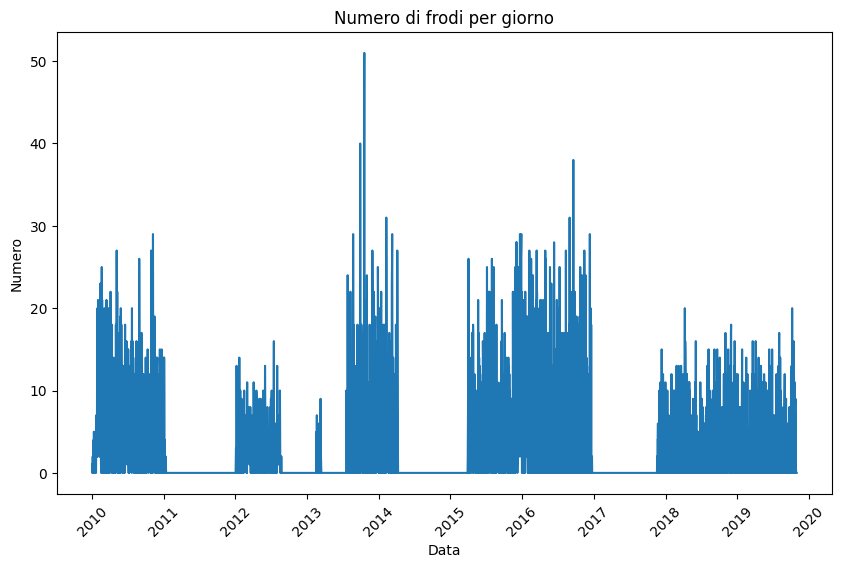

In [39]:
fraud_by_day = trans_final.groupby('day')['fraud'].agg('sum')
plt.figure(figsize=(10, 6))
sns.lineplot(fraud_by_day)
plt.title('Numero di frodi per giorno')
plt.xlabel('Data')
plt.ylabel('Numero')
plt.xticks(rotation=45)

numero di frodi per intervallo di tempo


In [40]:
def intervallo_temporale(ora):
    hour = ora.hour
    if 0 <= hour < 4:
        return 'Intervallo1 (00:00-03:59)'
    elif 4 <= hour < 8:
        return 'Intervallo2 (04:00-07:59)'
    elif 8 <= hour < 12:
        return 'Intervallo3 (08:00-11:59)'
    elif 12 <= hour < 16:
        return 'Intervallo4 (12:00-15:59)'
    elif 16 <= hour < 20:
        return 'Intervallo5 (16:00-19:59)'
    elif 20 <= hour < 24:
        return 'Intervallo6 (20:00-23:59)'

# Applicare la funzione sulla colonna 'time' e creare una nuova colonna 'intervallo'
trans_final['intervallo_temporale'] = trans_final['time'].apply(intervallo_temporale)

([0, 1, 2, 3, 4, 5],
 [Text(0, 0, 'Intervallo1 (00:00-03:59)'),
  Text(1, 0, 'Intervallo2 (04:00-07:59)'),
  Text(2, 0, 'Intervallo3 (08:00-11:59)'),
  Text(3, 0, 'Intervallo4 (12:00-15:59)'),
  Text(4, 0, 'Intervallo5 (16:00-19:59)'),
  Text(5, 0, 'Intervallo6 (20:00-23:59)')])

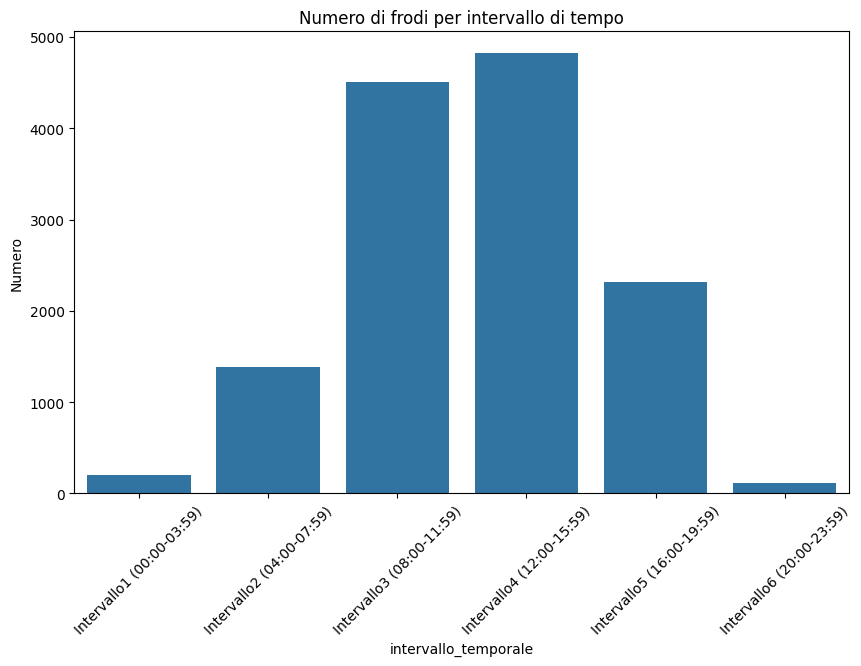

In [41]:
trans_final['year'] = pd.to_datetime(trans_final['day']).dt.year
trans_final['month'] = pd.to_datetime(trans_final['day']).dt.month
trans_final.shape
fraud_by_tid = trans_final.groupby('intervallo_temporale')['fraud'].agg('sum')

plt.figure(figsize=(10, 6))
sns.barplot(x=pd.DataFrame(fraud_by_tid).index, y= 'fraud', data=pd.DataFrame(fraud_by_tid))
plt.title('Numero di frodi per intervallo di tempo')
plt.ylabel('Numero')
plt.xticks(rotation=45)

tasso di frodi per intervallo di tempo (non ho capito bene che cambia da sopra, in caso sia importante da fare anche per i tipi di attività colpite da frodi)

In [42]:
fraud_by_int_mean = trans_final.groupby('intervallo_temporale')['fraud'].agg('mean')*100

([0, 1, 2, 3, 4, 5],
 [Text(0, 0, 'Intervallo1 (00:00-03:59)'),
  Text(1, 0, 'Intervallo2 (04:00-07:59)'),
  Text(2, 0, 'Intervallo3 (08:00-11:59)'),
  Text(3, 0, 'Intervallo4 (12:00-15:59)'),
  Text(4, 0, 'Intervallo5 (16:00-19:59)'),
  Text(5, 0, 'Intervallo6 (20:00-23:59)')])

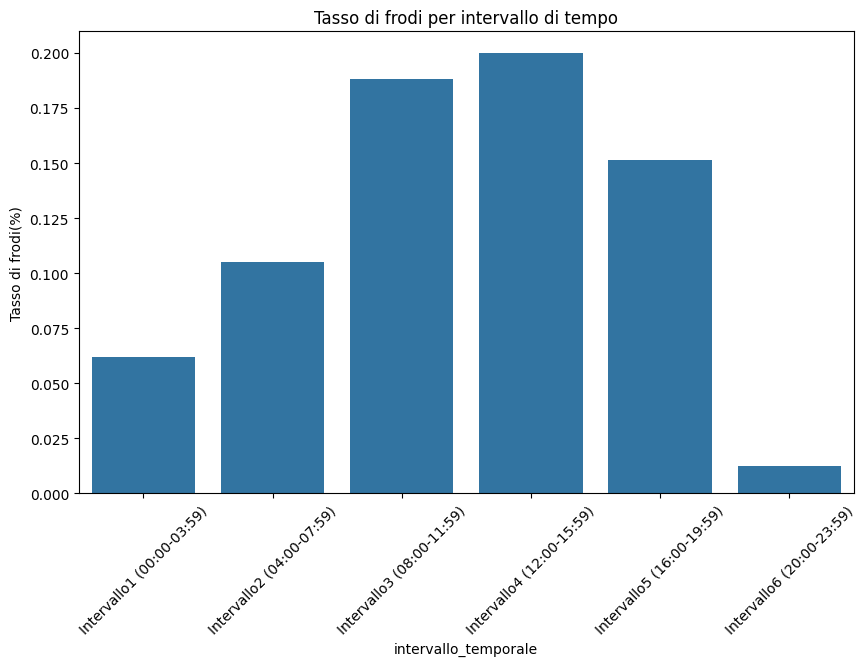

In [43]:
plt.figure(figsize=(10, 6))
sns.barplot(x=pd.DataFrame(fraud_by_int_mean).index, y= 'fraud', data=pd.DataFrame(fraud_by_int_mean))
plt.title('Tasso di frodi per intervallo di tempo')
plt.ylabel('Tasso di frodi(%)')
plt.xticks(rotation=45)

tasso di frodi al mese

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 [Text(0, 0, '1'),
  Text(1, 0, '2'),
  Text(2, 0, '3'),
  Text(3, 0, '4'),
  Text(4, 0, '5'),
  Text(5, 0, '6'),
  Text(6, 0, '7'),
  Text(7, 0, '8'),
  Text(8, 0, '9'),
  Text(9, 0, '10'),
  Text(10, 0, '11'),
  Text(11, 0, '12')])

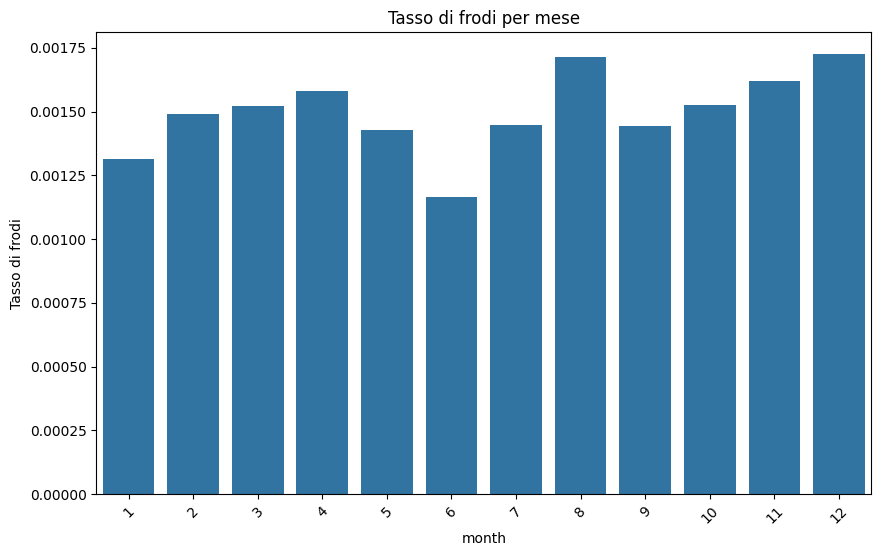

In [44]:
fraud_by_month = trans_final.groupby('month')['fraud'].agg('mean')

plt.figure(figsize=(10, 6))
sns.barplot(x=pd.DataFrame(fraud_by_month).index, y= 'fraud', data=pd.DataFrame(fraud_by_month))
plt.title('Tasso di frodi per mese')
plt.ylabel('Tasso di frodi')
plt.xticks(rotation=45)

Text(0.5, 1.0, 'Distribuzione geografica di tutte le frodi')

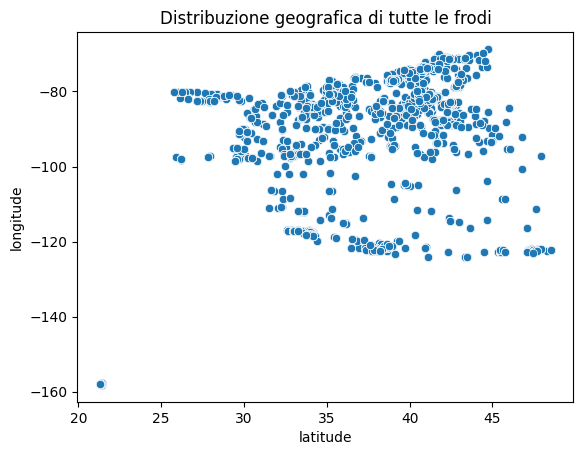

In [45]:
trans_fraud = trans_final.loc[trans_final['fraud']==1,:]
sns.scatterplot(x ='latitude', y='longitude', data = trans_fraud)
plt.title("Distribuzione geografica di tutte le frodi")

tipologie di attività commerciali colpite da frodi

Text(0, 0.5, 'Tipo di attività')

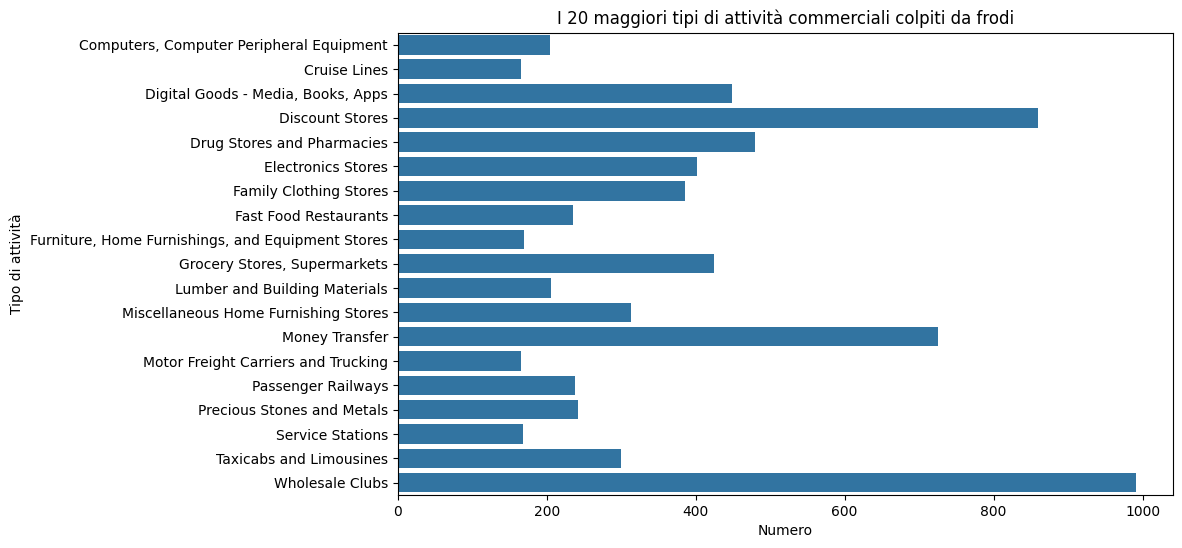

In [46]:
fraud_by_mcc = trans_final.groupby('mcc_description')['fraud'].agg('sum').sort_values(ascending = False)
fraud_by_mcc_20 = pd.DataFrame({'tasso': fraud_by_mcc[1:20], 'tipo': fraud_by_mcc[1:20].index.astype("category")})

plt.figure(figsize=(10, 6))
sns.barplot(data=fraud_by_mcc_20, y = 'tipo',x='tasso' )
plt.title('I 20 maggiori tipi di attività commerciali colpiti da frodi')
plt.xlabel('Numero')
plt.ylabel('Tipo di attività')

circuiti delle carte


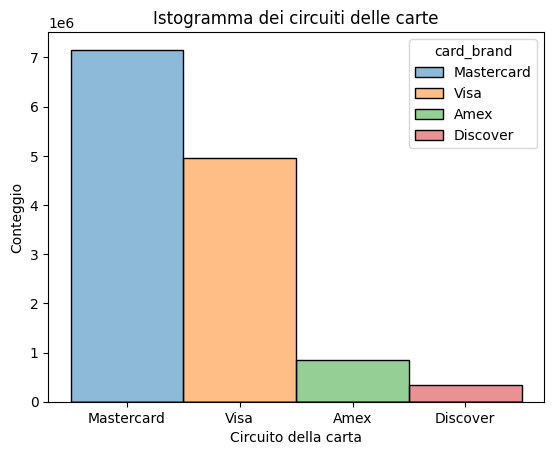

In [48]:

sns.histplot(data=trans_final, x='card_brand', hue='card_brand')

# Add title
plt.title("Istogramma dei circuiti delle carte")
plt.xlabel("Circuito della carta")
plt.ylabel("Conteggio")
plt.show()


distribuzione uomini/donne nel dataset

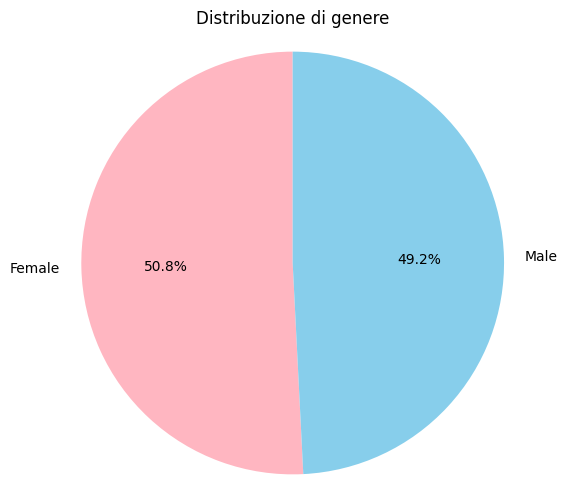

In [49]:
gender_count = users['gender'].value_counts()
plt.figure(figsize=(6, 6))
plt.pie(gender_count, labels=gender_count.index, autopct='%1.1f%%', startangle=90, colors=['lightpink','skyblue'])
plt.title('Distribuzione di genere')
plt.axis('equal')  
plt.show()

transazioni effettuate da uomini e donne

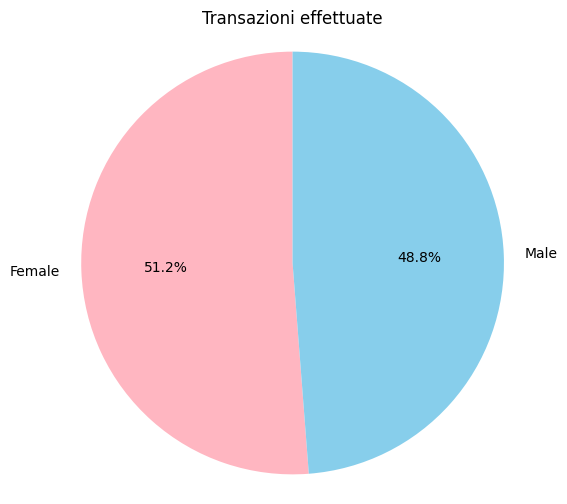

In [50]:
gender_count = trans_final['gender'].value_counts()
plt.figure(figsize=(6, 6))
plt.pie(gender_count, labels=gender_count.index, autopct='%1.1f%%', startangle=90, colors=['lightpink','skyblue'])
plt.title('Transazioni effettuate')
plt.axis('equal')  
plt.show()

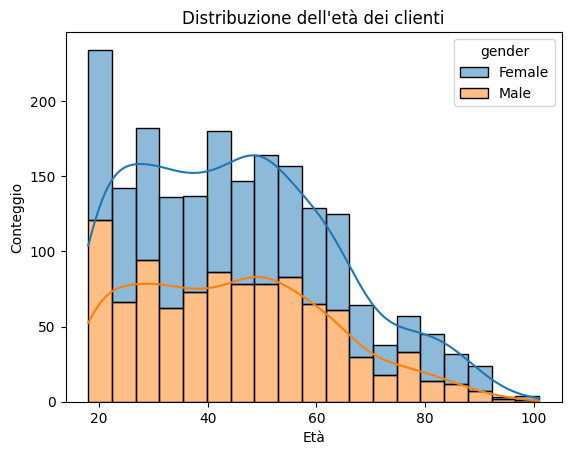

In [51]:
sns.histplot(data = users, x = 'current_age', hue = 'gender', multiple = 'stack', kde = True)
plt.title('Distribuzione dell\'età dei clienti')
plt.xlabel('Età')
plt.ylabel('Conteggio')
plt.show()


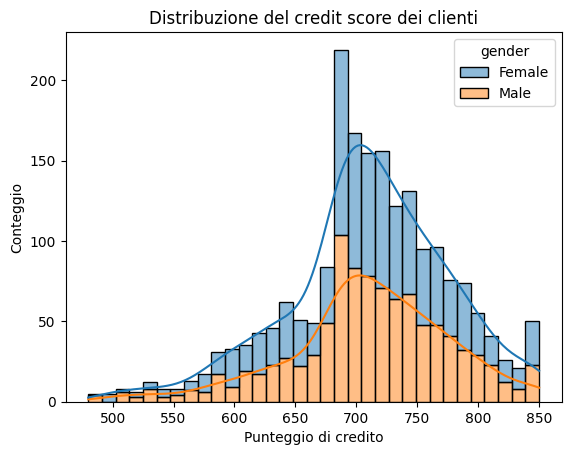

In [52]:
sns.histplot(data = users, x = 'credit_score', hue = 'gender', multiple = 'stack', kde = True)
plt.title('Distribuzione del credit score dei clienti')
plt.xlabel('Punteggio di credito')
plt.ylabel('Conteggio')
plt.show()

Un credit score (punteggio di credito) viene solitamente calcolato da agenzie di credito utilizzando modelli che assegnano un punteggio numerico, basato sulla tua storia finanziaria e su vari fattori, come i pagamenti, i debiti, la durata della tua storia creditizia, ecc.

Punteggio Inferiore a 580:

Molto basso: Questo punteggio indica una gestione del credito non ottimale, con probabilità di incorrere in difficoltà nel pagare i debiti.

Le persone con punteggi così bassi potrebbero avere difficoltà ad accedere a prestiti o carte di credito, o potrebbero affrontare tassi di interesse molto alti.

580 - 669:

Adeguato: Punteggio inferiore alla media, ma non così basso da escludere l'accesso a prestiti o carte di credito.

Potresti ancora essere in grado di ottenere credito, ma con tassi di interesse più alti rispetto a chi ha un punteggio di credito migliore.

670 - 739:

Buono: Questo è un punteggio di credito nella media. Le persone con punteggi in questa fascia hanno probabilità di ricevere condizioni di credito favorevoli, ma non sono considerati eccellenti.

È un buon punteggio per ottenere prestiti o carte di credito con tassi di interesse moderati.

740 - 799:

Molto buono: Le persone con questo punteggio hanno una storia di credito solida e sono generalmente considerate a basso rischio per le istituzioni finanziarie.

È facile ottenere credito con tassi di interesse favorevoli.

800 e oltre:

Eccellente: Questo è il punteggio più alto e indica una gestione impeccabile delle finanze e una lunga storia di pagamenti puntuali. Le persone con un punteggio in questa fascia possono ottenere i migliori tassi di interesse e sono viste come molto affidabili.

In [53]:
# bins, labels e score_band come prima
bins   = [0, 579, 669, 739, 799, 999]
labels = ['Molto basso','Adeguato','Buono','Molto buono','Eccellente']

users['score_band'] = pd.cut(
    users['credit_score'],
    bins=bins,
    labels=labels,
    right=True,
    include_lowest=True
)

# colori CSS per fascia
color_map = {
    'Molto basso':   'red',
    'Adeguato':      'orange',
    'Buono':         'yellow',
    'Molto buono':   'lightgreen',
    'Eccellente':    'green'
}

# centro mappa
center = [users['latitude'].mean(), users['longitude'].mean()]

# crea la mappa senza cluster
m = folium.Map(location=center, zoom_start=6, tiles='CartoDB positron')

# aggiungi ogni cerchio direttamente alla mappa
for _, row in users.iterrows():
    folium.CircleMarker(
        location=[row.latitude, row.longitude],
        radius=4,
        color=color_map[row.score_band],
        fill=True, fill_opacity=0.6,
        popup=f"{row.score_band} ({row.credit_score})"
    ).add_to(m)

# mostra mappa (se in notebook basta mettere m alla fine della cella)
m


In [54]:
trans_final.columns

Index(['id_trans', 'client_id_trans', 'card_id', 'amount', 'use_chip',
       'merchant_id', 'merchant_city', 'merchant_state', 'day', 'time',
       'fraud', 'client_id_card', 'card_brand', 'card_type', 'expires',
       'has_chip', 'num_cards_issued', 'credit_limit', 'acct_open_date',
       'year_pin_last_changed', 'card_valid_month', 'id', 'current_age',
       'retirement_age', 'birth_year', 'gender', 'address', 'latitude',
       'longitude', 'per_capita_income', 'yearly_income', 'total_debt',
       'credit_score', 'num_credit_cards', 'years_to_retire',
       'mcc_description', 'intervallo_temporale', 'year', 'month'],
      dtype='object')

In [55]:
temp = cards.groupby('client_id').agg(total_credit_limit = ('credit_limit', 'sum'), total_cards = ('id', 'count'))
temp


total_credit_limit  total_cards
client_id                                 
0                    105656.0            4
1                     41805.0            3
2                     50361.0            5
3                     13722.0            4
4                    136202.0            5
...                       ...          ...
1995                  30965.0            4
1996                  47175.0            3
1997                 142669.0            7
1998                    538.0            3
1999                  21995.0            2

[2000 rows x 2 columns]

<Axes: xlabel='total_credit_limit', ylabel='Count'>

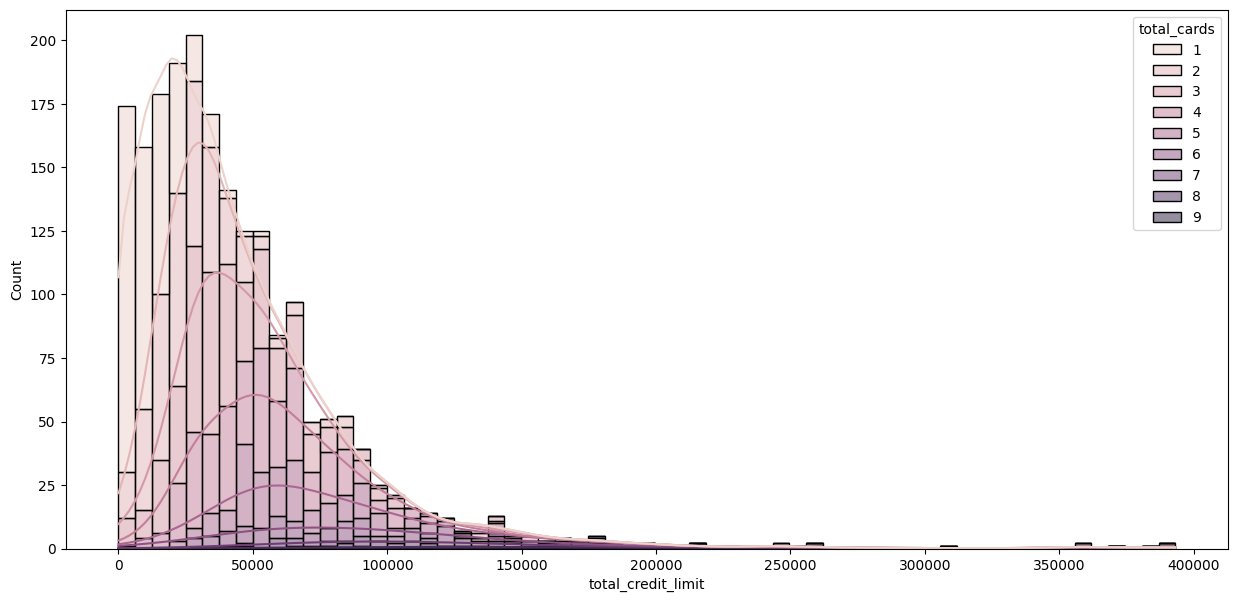

In [56]:
plt.figure(figsize = (15,7))
sns.histplot(data = temp, x  = 'total_credit_limit', hue = 'total_cards', multiple = 'stack'    , kde = True)

conteggio del numero di carte presenti nel dark web

card_on_dark_web
No    6146
Name: count, dtype: int64


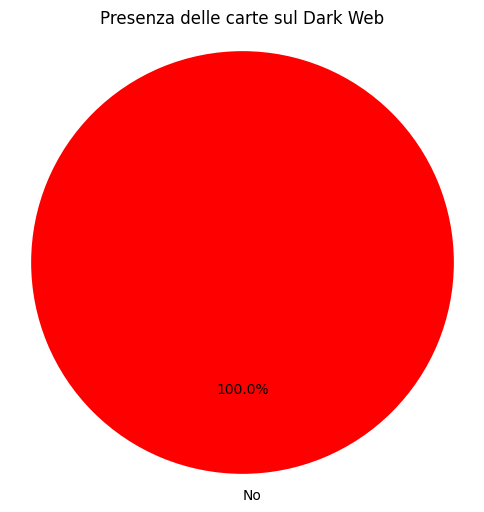

In [57]:
card_darkweb_count = cards['card_on_dark_web'].value_counts()
print(card_darkweb_count)
plt.figure(figsize=(6,6))
plt.pie(card_darkweb_count, labels=card_darkweb_count.index, autopct='%1.1f%%', startangle=90, colors=['red', 'green'])
plt.title('Presenza delle carte sul Dark Web')
plt.axis('equal')
plt.show()

## VERSO LA CLASSIFICAZIONE

eliminazione righe in cui non si ha informazione sull'eventuale frode

In [67]:
trans_final.dropna(subset=['fraud'], inplace=True)
trans_final.info()

NameError: name 'trans_final' is not defined

selezionare quali colonne utilizzare per il modello

In [ ]:
trans_final.column

Index(['id_trans', 'client_id_trans', 'card_id', 'amount', 'use_chip',
       'merchant_id', 'merchant_city', 'merchant_state', 'day', 'time',
       'fraud', 'client_id_card', 'card_brand', 'card_type', 'expires',
       'has_chip', 'num_cards_issued', 'credit_limit', 'acct_open_date',
       'year_pin_last_changed', 'card_valid_month', 'id', 'current_age',
       'retirement_age', 'birth_year', 'gender', 'address', 'latitude',
       'longitude', 'per_capita_income', 'yearly_income', 'total_debt',
       'credit_score', 'num_credit_cards', 'years_to_retire',
       'mcc_description'],
      dtype='object')

trasformazione delle colonne categoriche in numeriche, non uso get_dummies poiché dato che la tabella è già grande la farebbe ingrandire troppo a livello di GB (come da errore python)

In [59]:
le = LabelEncoder()
for column in ['mcc_description', 'merchant_city', 'merchant_state','use_chip','card_brand','card_type','gender','has_chip']:
    trans_final[column] = le.fit_transform(trans_final[column])

eliminazione colonne non di interesse per la classificazione

In [66]:
to_drop = ['id_trans','client_id_trans','card_id','client_id_card','id','retirement_age','address','expires','day','time','fraud','intervallo_temporale']
#del trans_final
x = trans_final.drop(to_drop, axis=1)
y = trans_final['fraud']
del trans_final

NameError: name 'trans_final' is not defined

In [61]:
y.value_counts()

fraud
0.0    8901631
1.0      13332
Name: count, dtype: int64

undersampling per bilanciare il dataset

In [63]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(sampling_strategy={0: len(y[y==1]) * 3,  1: len(y[y==1])}, 
                         random_state=42)
x_res, y_res = rus.fit_resample(x, y)

print(y_res.value_counts())
# 1: 10696, 0: 32088


fraud
0.0    39996
1.0    13332
Name: count, dtype: int64


In [64]:
x_res.head(10)

amount  use_chip  merchant_id  merchant_city  merchant_state  \
9060707    52.680000         0        19114           9061             123   
2111603   167.199997         1         9932           7822             132   
2231752    15.210000         2        25887           3473             130   
8181621    10.200000         0        50783           1894              69   
7075728   209.000000         0        44795            224               1   
9547187    12.660000         0        79659           1714             172   
1358020    80.000000         2        27092           6196              24   
3828216     3.400000         2        61195           1239             123   
13210513   51.209999         0        69956            719              69   
11393761   68.000000         0        59935          11027              53   

          card_brand  card_type  has_chip  num_cards_issued  credit_limit  \
9060707            3          1         1                 2       29573.0   
2111603            3          0         1                 2        6400.0   
2231752            3          0         1                 2       13200.0   
8181621            0          0         1                 2       11300.0   
7075728            3          0         1                 1       10300.0   
9547187            3          1         1                 2       22641.0   
1358020            2          1         1                 2        4598.0   
3828216            2          1         1                 1       14541.0   
13210513           2          1         1                 1       20447.0   
11393761           2          2         1                 1          96.0   

          ... per_capita_income  yearly_income  total_debt  credit_score  \
9060707   ...           25109.0        51196.0     67164.0           631   
2111603   ...           16703.0        34057.0     59247.0           655   
2231752   ...           21992.0        44839.0     63194.0           625   
8181621   ...           25365.0        36335.0     28929.0           676   
7075728   ...           24196.0        49335.0     51520.0           773   
9547187   ...           30418.0        62019.0     85666.0           543   
1358020   ...           12349.0        11566.0      9102.0           536   
3828216   ...           23316.0        47542.0      2667.0           725   
13210513  ...           24509.0        49967.0     58582.0           712   
11393761  ...           22682.0        34220.0         0.0           745   

          num_credit_cards  years_to_retire  mcc_description  \
9060707                  4               14               34   
2111603                  4               17               26   
2231752                  3                6               39   
8181621                  2                0               45   
7075728                  3               31               21   
9547187                  4               19               77   
1358020                  4                0               70   
3828216                  3               31               87   
13210513                 4               26               30   
11393761                 5                0               64   

               intervallo_temporale  year  month  
9060707   Intervallo5 (16:00-19:59)  2016     10  
2111603   Intervallo3 (08:00-11:59)  2011      9  
2231752   Intervallo2 (04:00-07:59)  2011     10  
8181621   Intervallo3 (08:00-11:59)  2016      2  
7075728   Intervallo4 (12:00-15:59)  2015      5  
9547187   Intervallo2 (04:00-07:59)  2017      2  
1358020   Intervallo4 (12:00-15:59)  2011      2  
3828216   Intervallo2 (04:00-07:59)  2012     12  
13210513  Intervallo5 (16:00-19:59)  2019     10  
11393761  Intervallo2 (04:00-07:59)  2018      6  

[10 rows x 28 columns]

Downcast delle colonne numeriche di x e y per risparmiare memoria dato che la tabella occupa molto spazio.

In [65]:
# x = x.apply(pd.to_numeric, downcast='integer')  
# x = x.apply(pd.to_numeric, downcast='float')    


# y = pd.to_numeric(y, downcast='integer') 

# print(x.info(memory_usage='deep'))

x_res = x_res.apply(pd.to_numeric, downcast='integer')  
x_res = x_res.apply(pd.to_numeric, downcast='float')    


y_res = pd.to_numeric(y_res, downcast='integer') 

print(x_res.info(memory_usage='deep'))

ValueError: Unable to parse string "Intervallo5 (16:00-19:59)" at position 0

In [ ]:
x.head(10)

amount  use_chip  merchant_id  merchant_city  merchant_state  \
0  -77.000000         2      59935.0            817             117   
1   14.570000         2      67570.0            816              67   
2   80.000000         2      27092.0          11331              24   
4   46.410000         2      13051.0           4595              94   
5    4.810000         2      20519.0           1226             123   
7   26.459999         1      39021.0           7822             132   
10   3.510000         2      67570.0           8332             172   
11   2.580000         2      75781.0           1239             123   
12  39.630001         2      59935.0            817             117   
13  43.330002         2      33326.0           5325              62   

    card_brand  card_type  has_chip  num_cards_issued  credit_limit  ...  \
0            2          2         1                 2          55.0  ...   
1            2          0         1                 1        9100.0  ...   
2            2          1         1                 1       14802.0  ...   
4            3          1         1                 1       19113.0  ...   
5            2          2         1                 1          89.0  ...   
7            2          2         1                 1          46.0  ...   
10           3          1         0                 1       25658.0  ...   
11           3          1         1                 2        1484.0  ...   
12           2          2         1                 2          55.0  ...   
13           3          1         1                 2       23237.0  ...   

    gender   latitude   longitude  per_capita_income  yearly_income  \
0        0  46.799999 -100.760002            23679.0        48277.0   
1        1  40.799999  -91.120003            18076.0        36853.0   
2        1  33.180000 -117.290001            16894.0        34449.0   
4        1  38.860001  -76.599998            33529.0        68362.0   
5        0  40.840000  -73.870003            25537.0        52065.0   
7        1  36.340000  -83.279999            13668.0        27861.0   
10       1  29.660000  -95.040001            26170.0        53357.0   
11       1  40.639999  -73.940002            23316.0        47542.0   
12       0  46.799999 -100.760002            23679.0        48277.0   
13       1  37.709999 -122.160004            24971.0        30962.0   

    total_debt  credit_score  num_credit_cards  years_to_retire  \
0     110153.0           740                 4               37   
1     112139.0           834                 5               19   
2      36540.0           686                 3               16   
4      96182.0           711                 2               18   
5      98613.0           828                 5               18   
7     108313.0           782                 5                9   
10    114266.0           690                 5                8   
11      2667.0           725                 3               31   
12    110153.0           740                 4               37   
13     15336.0           743                 5                0   

    mcc_description  
0                64  
1                26  
2                70  
4                32  
5                12  
7                99  
10               26  
11               45  
12               64  
13               96  

[10 rows x 25 columns]

# CORRELATION ANALYSIS

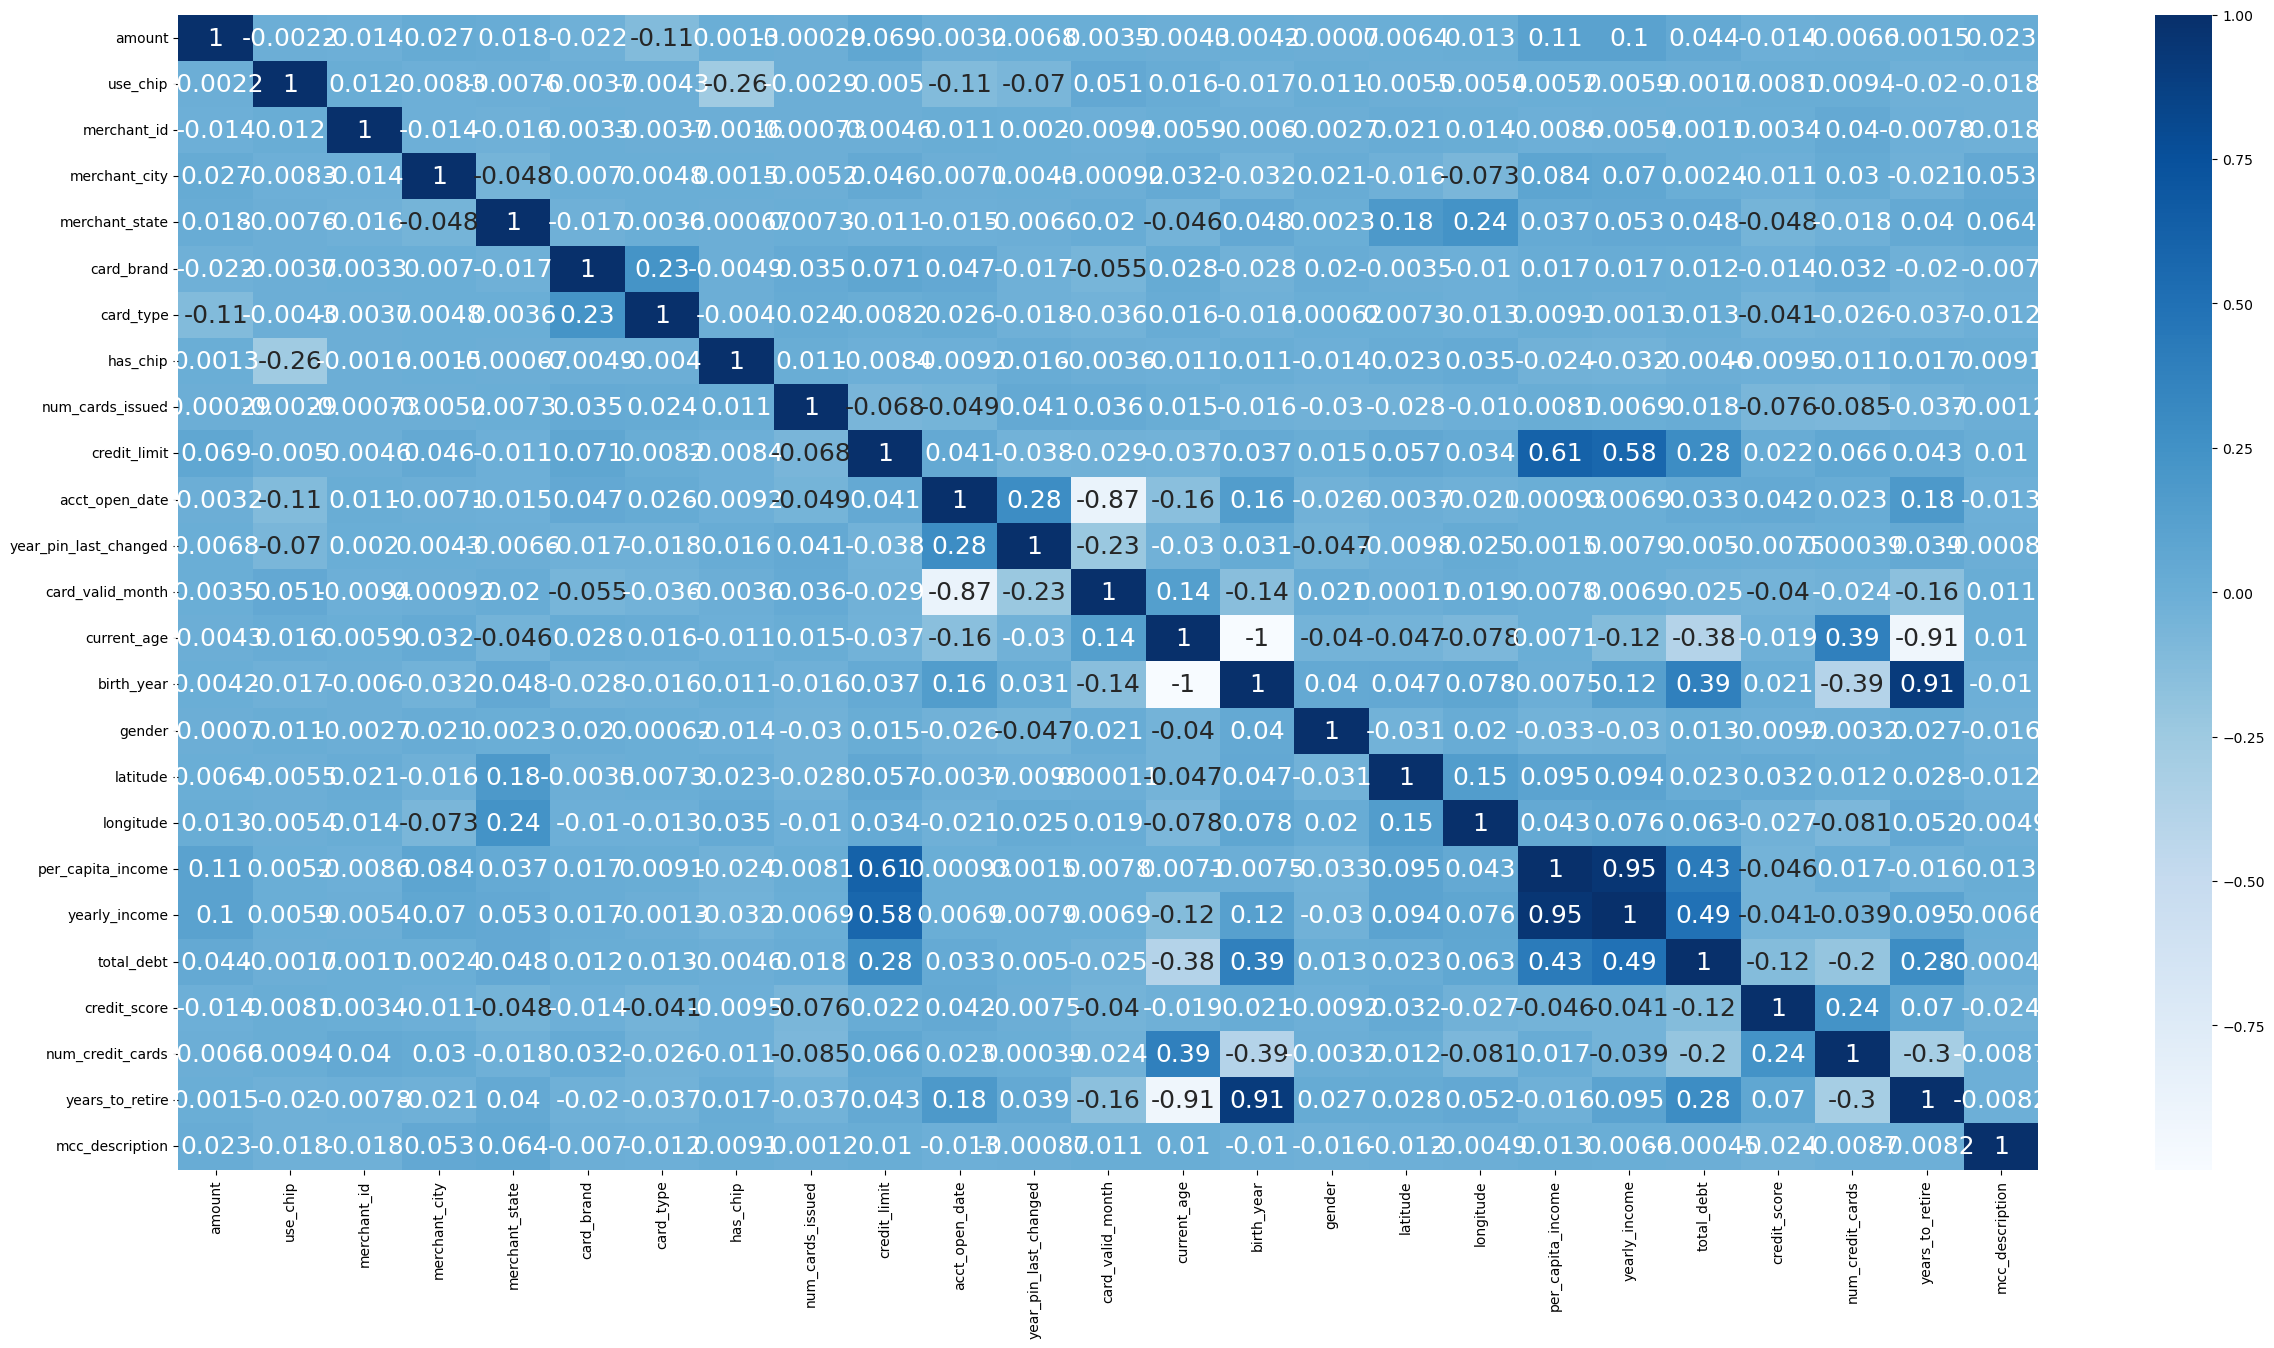

In [ ]:
plt.figure(figsize=(30,15))
ax = sns.heatmap(x[x.columns].corr(),cmap="Blues",annot=True,annot_kws={"size": 18})

eliminare le correlazioni con valore maggiore di 0.8

In [ ]:
import numpy as np

# Calcola la matrice di correlazione (senza abs)
corr_matrix = x.corr()

# Considera solo la metà superiore della matrice
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

for col in upper.columns:
    for row in upper.index:
        corr_value = upper.loc[row, col]
        if abs(corr_value) > 0.8:
            print(f"{row} vs {col}: correlazione = {corr_value:.2f}")
        

acct_open_date vs card_valid_month: correlazione = -0.87
current_age vs birth_year: correlazione = -1.00
per_capita_income vs yearly_income: correlazione = 0.95
current_age vs years_to_retire: correlazione = -0.91
birth_year vs years_to_retire: correlazione = 0.91


In [ ]:
x_res.drop(['years_to_retire','birth_year','card_valid_month','per_capita_income'], axis=1, inplace=True)

In [ ]:
# # Trova le colonne con |correlazione| > 0.8 (cioè > 0.8 o < -0.8)
# to_drop = [column for column in upper.columns if any((upper[column] > 0.8) | (upper[column] < -0.8))]

# # Elimina le colonne correlate
# x_reduced = x.drop(columns=to_drop)

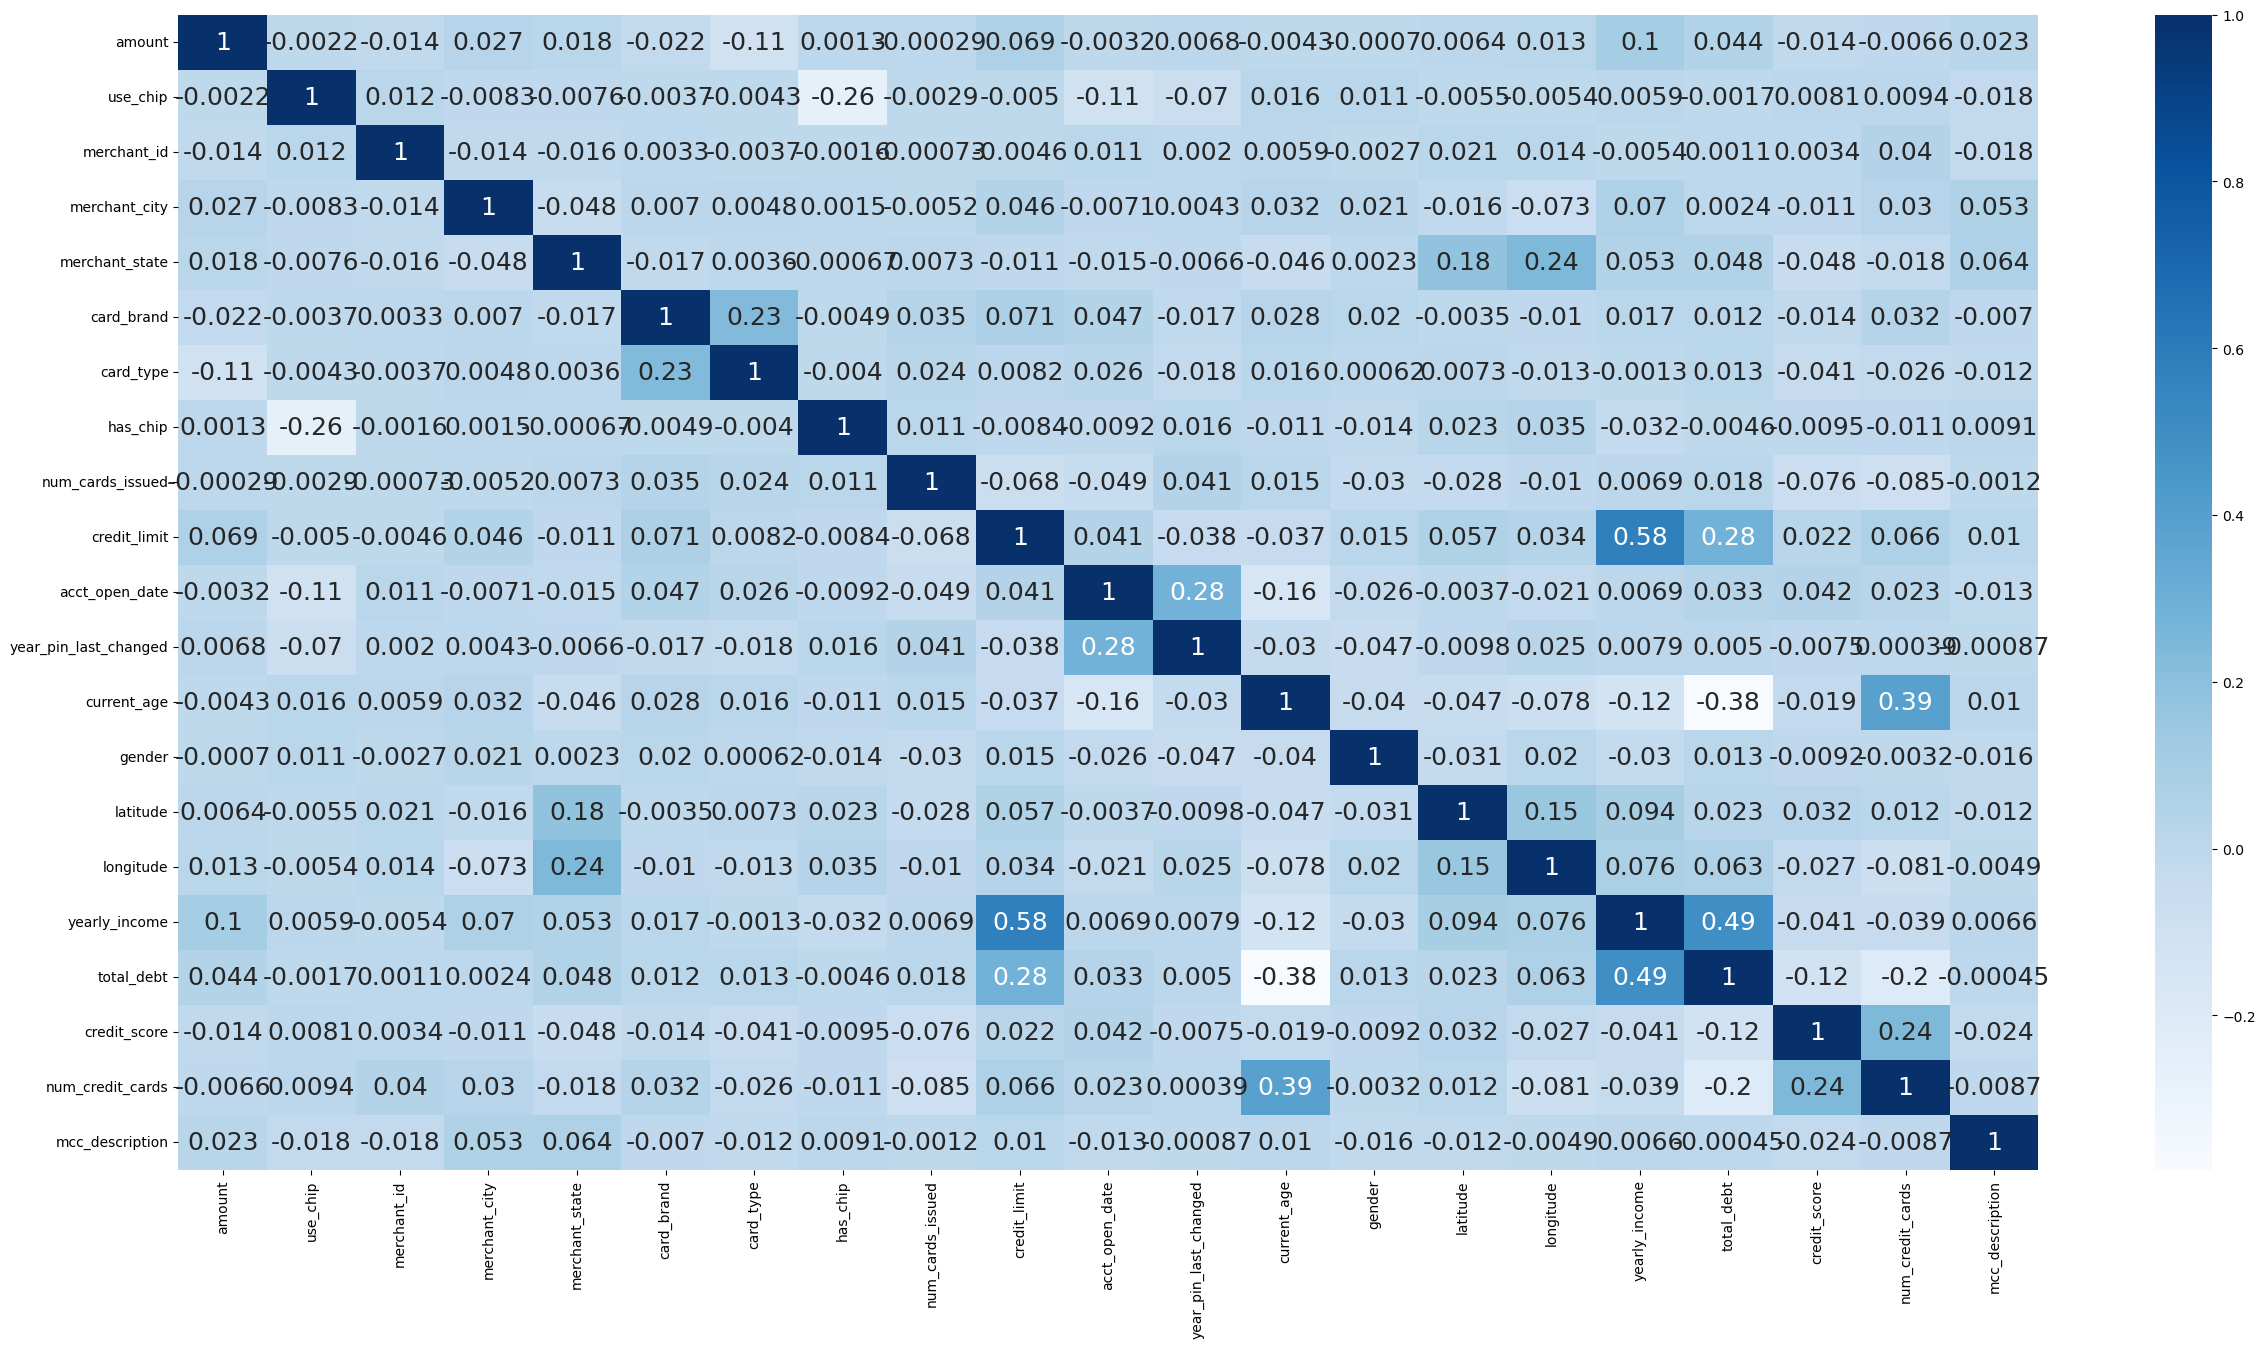

In [ ]:
plt.figure(figsize=(30,15))
ax = sns.heatmap(x[x.columns].corr(),cmap="Blues",annot=True,annot_kws={"size": 18})

## CLASSIFICAZIONE

In [ ]:
# Random state
rs = 42

# Split the data to check which algorithms learn better (later on we can check )
x_train, x_test, y_train, y_test = train_test_split(x_res, y_res, test_size=0.2, random_state=rs)

# look at the shape of the data (many problems can arise from wrong shape)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(42662, 21)
(10666, 21)
(42662,)
(10666,)


In [ ]:
y_train.value_counts()

fraud
0    32022
1    10640
Name: count, dtype: int64

In [ ]:
def generate_model_report(model, X_test, y_test):
    # 1. Predizioni “dure” e metriche base
    y_pred = model.predict(X_test)
    acc       = accuracy_score(y_test, y_pred)
    prec      = precision_score(y_test, y_pred)
    rec       = recall_score(y_test, y_pred)
    f1        = f1_score(y_test, y_pred)
    
    # 2. ROC AUC “dura” (senza probabilità) opzionale
    try:
        auc_hard = roc_auc_score(y_test, y_pred)
    except ValueError:
        auc_hard = None

    print(f"Model: {model.__class__.__name__}")
    print(f" Accuracy:  {acc:.4f}")
    print(f" Precision: {prec:.4f}")
    print(f" Recall:    {rec:.4f}")
    print(f" F1-score:  {f1:.4f}")
    if auc_hard is not None:
        print(f" ROC AUC (hard labels): {auc_hard:.4f}")
    print()

    # 3. Confusion matrix
    cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
    disp = ConfusionMatrixDisplay(cm, display_labels=model.classes_)
    disp.plot(cmap='Blues')
    plt.title(f"Confusion Matrix: {model.__class__.__name__}")
    plt.show()

    # 4. Curva ROC “soft” se possibile
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test)[:, 1]
    elif hasattr(model, "decision_function"):
        y_score = model.decision_function(X_test)
    else:
        print(f"  -> {model.__class__.__name__} non supporta predict_proba né decision_function, salto ROC curve.\n")
        return

    fpr, tpr, _ = roc_curve(y_test, y_score)
    auc_soft = roc_auc_score(y_test, y_score)

    plt.figure(figsize=(8, 6))
    sns.set(style='whitegrid')
    plt.plot(fpr, tpr, label=f"{model.__class__.__name__} (AUC = {auc_soft:.4f})", lw=2)
    plt.plot([0, 1], [0, 1], '--', color='gray')
    plt.title(f"ROC Curve: {model.__class__.__name__}")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()


In [ ]:
# 1) Prepara la lista dei modelli che vuoi confrontare
models = [
    ("LogisticRegression",   LogisticRegression(random_state=rs)),
    ("DecisionTree",         DecisionTreeClassifier(random_state=rs)), 
    ("RandomForest",         RandomForestClassifier(n_estimators = 10, random_state=rs)),
    ("AdaBoost",             AdaBoostClassifier()),
    ("GradientBoosting",     GradientBoostingClassifier(n_estimators = 10, random_state=rs)),
    ("LDA",                  LinearDiscriminantAnalysis()),
    ("SVC",                  SVC(probability=True))
]

# 1) Definisci il numero di fold e il generatore
n_splits = 5
cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=rs)

# 2) Prepara i punteggi che vuoi raccogliere
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score),
    'roc_auc': make_scorer(roc_auc_score, needs_proba=True)
}

# 3) Loop sui modelli per ottenere cross-validated scores
for name, clf in models:
    print("\n" + "="*40)
    print(f"K-Fold CV for {name} ({n_splits} folds)")
    print("="*40)

    # Esegui cross_validate
    cv_results = cross_validate(
        estimator=clf,
        X=x_res,
        y=y_res,
        cv=cv,
        scoring=scoring,
        return_train_score=False
    )

    # Stampa media e deviazione standard per ciascuna metrica
    for metric in scoring:
        scores = cv_results[f'test_{metric}']
        print(f"{metric.capitalize():10s}: {scores.mean():.4f} ± {scores.std():.4f}")
    print()



K-Fold CV for LogisticRegression (5 folds)
Accuracy  : 0.7500 ± 0.0000
Precision : 0.0000 ± 0.0000
Recall    : 0.0000 ± 0.0000
F1        : 0.0000 ± 0.0000
Roc_auc   : 0.4953 ± 0.0014


K-Fold CV for DecisionTree (5 folds)
Accuracy  : 0.9536 ± 0.0020
Precision : 0.9074 ± 0.0024
Recall    : 0.9068 ± 0.0064
F1        : 0.9071 ± 0.0043
Roc_auc   : 0.9380 ± 0.0035


K-Fold CV for RandomForest (5 folds)
Accuracy  : 0.9626 ± 0.0014
Precision : 0.9523 ± 0.0016
Recall    : 0.8954 ± 0.0053
F1        : 0.9230 ± 0.0031
Roc_auc   : 0.9770 ± 0.0024


K-Fold CV for AdaBoost (5 folds)
Accuracy  : 0.9419 ± 0.0022
Precision : 0.9000 ± 0.0071
Recall    : 0.8636 ± 0.0047
F1        : 0.8814 ± 0.0043
Roc_auc   : 0.9668 ± 0.0024


K-Fold CV for GradientBoosting (5 folds)
Accuracy  : 0.9219 ± 0.0029
Precision : 0.9084 ± 0.0049
Recall    : 0.7648 ± 0.0091
F1        : 0.8304 ± 0.0068
Roc_auc   : 0.9432 ± 0.0050


K-Fold CV for LDA (5 folds)
Accuracy  : 0.7626 ± 0.0054
Precision : 0.5686 ± 0.0308
Recall    : 0.